## 背景
对客户投诉进行分类具有重要意义，可帮助企业更好地了解问题类型、优化资源分配、改善客户体验，并提供数据支持，从而全面提升企业的运营水平和客户满意度。通过系统记录和分析不同类型的投诉，企业能更准确地把握客户需求和痛点，有针对性地改进产品和服务，提高客户满意度；同时，优化资源分配，集中资源解决最迫切的问题，提高效率；改善客户体验，增加客户信任和忠诚度；最后，提供数据支持，为企业决策提供科学依据，全面提升企业的运营水平和客户满意度。
## 数据
数据包含3个文件：train.csv、test.csv、validation.csv，分别是训练集、测试集和验证集。
数据形式如下：
|	|label|	text|
|--|--|--|
|1	|1	|用户投诉的内容户致电反映账单异常前台预处理情况经系统查询到户账单，并跟户...|
|2	|1	|退费业务包年到期接入码退费类型月基本费退费原因乙方无责客户安抚退费年月年月至...|
|3	|1	|户致电反映手机有信号无法正常拨打电话问题，已按预处理步骤处理，户已...|
|4	|1	|接入方式光纤到户故障单号故障现象无法连接上网故障申告时间是否为时限内第次催修障...|
|5	|1	|交易订单商户订单金额：元客户来电称其在软件错误充值元到其他人号码，要求我...|
## 项目流程
1.文件读取和数据拆分。<br>
2.分词、去停用词。读取同目录下的停用词表，用结巴分词器对文本进行分词、去停用词。<br>
3.创建词表。遍历文本，以字典形式统计词频，将词在字典的位置映射为索引，并在字典中加入未知和填充符号。<br>
4.创建Dataset和DataLoader并实例化。<br>
5.搭建自己的TextCNN模型。根据前向传播和输出的模型结构搭建模型。<br>
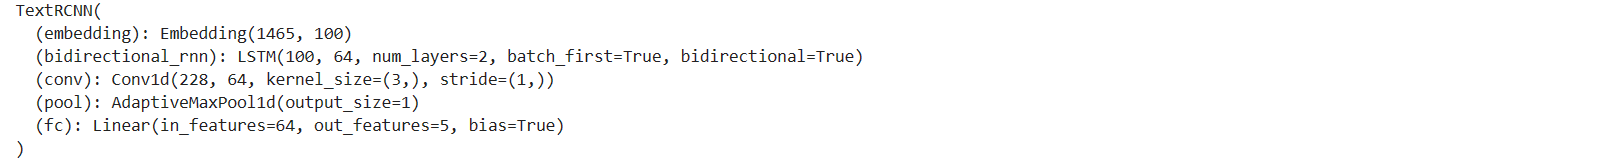
6.模型训练验证测试。进行模型的训练评估，并查看在测试集上的效果。<br>

In [1]:
import pandas as pd
import jieba
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch

## 文件读取和数据拆分

In [2]:
'''
读取训练、验证、测试数据，将训练集的文本和标签分别取出，文本用于制作词-id表。
'''

# 读取训练、测试、验证集的文件
train = pd.read_csv('train.csv', nrows=2000)  # 读取名为“train”的csv文件，读取前2000行
test = pd.read_csv('test.csv', nrows=400) # 读取名为“test”的csv文件，读取前400行
valid = pd.read_csv('validation.csv', nrows=400) # 读取名为“validation”的csv文件，读取前400行

# 将训练数据按照文本和标签进行拆分
texts = train['text'].values
labels = train['label'].values

## 分词、去停用词

<font size=4 color=Blue>知识点1：按行读取停用词表，去除字符串两端空白字符。</font><br>

In [3]:
'''
分词、去停用词
1.创建读取停用词表函数，按行读取停用词。
2.创建分词函数，逐行条文本分词，去停用词。
'''
# 读取停用词
def stopwords():
    with open('HGD_StopWords.txt', 'r', encoding='UTF-8') as f: # 读取停用词表中的停用词
        stopwords = set(line.strip() for line in f)  # 使用集合存储停用词，以便快速查找
    return stopwords

stop_words = stopwords()  
stop_words

{'',
 ':',
 '不择手段',
 '把',
 '三番五次',
 '三天两头',
 '［③①］',
 '恰好',
 '任凭',
 '呐',
 '差不多',
 '他',
 '与其',
 '为着',
 '从宽',
 '互相',
 '一方面',
 '％',
 '起',
 '从中',
 '几度',
 '倘若',
 '尽如人意',
 '凡',
 '以期',
 '不足',
 '要',
 '恰逢',
 '⑦',
 '强烈',
 '况且',
 '别人',
 '比如',
 '>>',
 '不仅仅',
 '哟',
 '几番',
 '合理',
 '尽可能',
 '当口儿',
 '嘎登',
 '③ａ',
 '［①Ｅ］',
 '更',
 '仍旧',
 '例如',
 '不再',
 '了',
 '复杂',
 '临到',
 '不限',
 '被',
 '单单',
 '呢',
 '归根到底',
 '＝',
 '虽',
 '从早到晚',
 '=',
 '［②③］',
 '［②②］',
 '即刻',
 'y',
 '7',
 '咳',
 '4',
 '庶几',
 '因着',
 '不尽然',
 '(',
 '可',
 '③ｈ',
 '＇',
 '哪',
 '只有',
 '各个',
 '照着',
 '［③ａ］',
 '＜Δ',
 '呕',
 '後面',
 '屡屡',
 '怪不得',
 '〕',
 '并排',
 '②',
 '呼哧',
 '②④',
 '具有',
 '总是',
 '尽量',
 'μ',
 '不成',
 '不得已',
 '::',
 '当前',
 '偏偏',
 '嘿',
 '由此可见',
 '②③',
 '多年来',
 '对应',
 '多亏',
 '并不是',
 '切勿',
 '》',
 '不是',
 '阿',
 '却不',
 '唉',
 '那么',
 '⑤',
 '凡是',
 '前进',
 '乘势',
 '管',
 '×××',
 '哈哈',
 '①⑤',
 '八成',
 '设使',
 '另一方面',
 '只消',
 '她是',
 '--',
 '替',
 '并',
 '同',
 'v',
 '如是',
 'φ',
 '只限',
 '诸位',
 '不然的话',
 '①③',
 '居然',
 '引起',
 '反倒是',
 '且说',
 '［②ｊ］',
 '急匆匆',
 '全体',
 '本',

<font size=4 color=Blue>知识点2：用结巴分词的精确模式进行分词，返回的是可迭代对象。</font><br>

In [4]:
# 分词、去停用词
def tokenizer(texts):
    word_cut = []
    # 遍历每个句子，对句子进行分词、去停用词
    for text in texts:
        words = [word for word in jieba.cut(text,cut_all=False) if word not in stop_words] # 使用jieba进行精确模式分词（返回可迭代对象），并去除停用词
        word_cut.append(words)
    return word_cut
#tokenizer_text = tokenizer(texts)
#tokenizer_text[1]

## 创建词表

<font size=4 color=Blue>知识点3：遍历文本，得到每个词出现的次数；枚举排序后的词语，将索引设为词汇表的索引，提取值的第一个元素（即词），构建一个词-id 映射表。将未知词和填充符号加入字典并赋予索引。</font><br>

In [5]:
'''
创建 词-id 表，使每个词都有唯一的数字映射，并设置未知词和填充词
1.创建字典，对每条文本中的词进行添加并计数，形成一个包含所有词的字典。
2.按照词频对词语进行计数，选取词频大于N的词，保留出现次数最多的M个值。（N，M为自己设定的值）
3.将单词在字典中的位置映射为 词-id 表的索引，并将未知词（'<UNK>'）和填充词（<PAD>）添加到词表。

'''
# 构建 词-id 表
MAX_VOCAB_SIZE = 15000 # 最长词表
MIN_WORD_FREQ = 5 # 最小词频
UNK, PAD = '<UNK>', '<PAD>'  # 未知字，填充符号
def build_vocab(texts, tokenizer, max_size, min_freq):
    # 定义一个空字典，用于存储单词及其出现次数
    vocab_dic = {}
    for line in tokenizer(texts):  # 对于每一行文本
        if not line:  # 跳过空行
            continue
        for word in line:  # 对于每一个词
            # 用.get()方法获取 word 的值，如果该词语不存在，则返回默认值 0。
            vocab_dic[word] = vocab_dic.get(word, 0) + 1  # 统计词出现次数,每次出现则加 1
    # 按照词出现次数从大到小排序，只保留出现次数最大的前max_size个单词
    vocab_list = sorted([_ for _ in vocab_dic.items() if _[1] >= min_freq], key=lambda x: x[1], reverse=True)[:max_size]
    # 构建一个字典，将词映射到它们在词汇表中的索引
    vocab_dic = {word_count[0]: idx for idx, word_count in enumerate(vocab_list)}
    # 添加两个特殊词，用于在文本序列中填充或替代未知词
    vocab_dic.update({UNK: len(vocab_dic), PAD: len(vocab_dic) + 1})    
    return vocab_dic

# 通过调用 build_vocab 函数可以得到一个词汇表，将单词映射为它们在词汇表中的索引
vocab = build_vocab(texts, tokenizer, MAX_VOCAB_SIZE, MIN_WORD_FREQ)
vocab

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.870 seconds.
Prefix dict has been built successfully.


{'用户': 0,
 '要求': 1,
 '谢谢': 2,
 '请': 3,
 '办理': 4,
 '解释': 5,
 '前台': 6,
 '来电': 7,
 '客户': 8,
 '号码': 9,
 '宽带': 10,
 '表示': 11,
 '费用': 12,
 '月': 13,
 '时间': 14,
 '接受': 15,
 '户': 16,
 '元': 17,
 '业务': 18,
 '跟进': 19,
 '查询': 20,
 '没有': 21,
 '现': 22,
 '协助': 23,
 '号': 24,
 '我司': 25,
 '营业厅': 26,
 '套餐': 27,
 '投诉': 28,
 '订单': 29,
 '名称': 30,
 '退费': 31,
 '联系': 32,
 '无法': 33,
 '问题': 34,
 '地址': 35,
 '欠费': 36,
 '对此': 37,
 '故障': 38,
 '工作人员': 39,
 '相关': 40,
 '无': 41,
 '告知': 42,
 '系统': 43,
 '需要': 44,
 '局方': 45,
 '年': 46,
 '致电': 47,
 '无效': 48,
 '争议': 49,
 '发生': 50,
 '核实': 51,
 '情况': 52,
 '核查': 53,
 '工号': 54,
 '是否': 55,
 '停机': 56,
 '受理': 57,
 '回复': 58,
 '称': 59,
 '类型': 60,
 '手机': 61,
 '部门': 62,
 '编码': 63,
 '备注': 64,
 '流量': 65,
 '内容': 66,
 '取消': 67,
 '优惠': 68,
 '给予': 69,
 '未': 70,
 '注销': 71,
 '服务': 72,
 '客户经理': 73,
 '方式': 74,
 '主叫': 75,
 '建议': 76,
 '都': 77,
 '接入': 78,
 '月份': 79,
 '上门': 80,
 '点': 81,
 '信息': 82,
 '名下': 83,
 '导致': 84,
 '现在': 85,
 '金额': 86,
 '反馈': 87,
 '上网': 88,
 '变更': 89,
 '师傅': 90,
 '原因': 91,
 '答复'

## 创建Dataset和DataLoader并实例化

<font size=4 color=Blue>知识点4：构造collate_batch函数，将每个batch_size中的序列填充为相同长度，填充值设置为 vocab['<PAD>'] ；</font><br>
<font size=4 color=Blue>知识点5：实例化DataLoader，设置batch_size，设置是否打乱，设置自定义函数；</font><br>

In [6]:
from torch.nn.utils.rnn import pad_sequence
'''
创建Dataset数据集和DataLoader数据加载器
1.创建数据集类，并在数据集内将文本转化为向量。
2.构造处理函数collate_fn，作用是对句子进行填充，使得每个batch内句子长度相同。
3.创建数据集实例。
4.设置batch size大小，创建数据加载器实例。
'''
# 创建Dataset和DataLoader
class TextDataset(Dataset):
    def __init__(self, data):
        # 初始化函数，接受数据作为参数
        
        # 将输入文本的句子列表进行分词，并将每个词转换为词表中的id
        # 为方便直接在此处理
        self.sequences = [[vocab.get(word, vocab.get(UNK)) for word in sentence] for sentence in tokenizer(data['text'].values)]
        
        # 保存标签
        self.labels = data['label'].values
        
    def __len__(self):
        # 返回数据集的长度
        return len(self.sequences)
    
    def __getitem__(self, idx):
        # 根据索引获取数据
        
        # 返回该索引对应的句子的词表id序列和标签
        return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx])

def collate_batch(batch):
    # 定义用于将一个batch的样本组合成一个张量的函数
    
    label_list, text_list = [], []
    # 遍历每个batch的数据
    for _text, _label in batch:
        label_list.append(_label)
        text_list.append(_text.clone().detach())
    
    # 对句子列表进行填充，使其长度一致
    text_list = pad_sequence(text_list, batch_first=True, padding_value=vocab['<PAD>'])
    label_list = torch.tensor(label_list, dtype=torch.int64)
    
    # 返回填充后的句子列表和标签列表
    return text_list, label_list


# 创建训练、测试和验证的数据集实例
train_data = TextDataset(train) # 训练
test_data = TextDataset(test) # 测试
valid_data = TextDataset(valid) # 验证

batch_size=32
# 创建训练、测试和验证的DataLoader实例
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch) # 训练
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch) # 测试
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch) # 验证

## 搭建自己的TextCNN模型

<font size=4 color=Blue>知识点6：词向量层搭建（词表大小，词嵌入维度）；双向LSTM层搭建（词向量为度，隐藏单元维度，LSTM层数，使用双向，设置输入维度）</font><br>
<font size=4 color=Blue>知识点7：1维卷积层（输入通道数，卷积核数量，卷积核大小）；自适应池化层；线性层；</font><br>

In [7]:
'''
搭建自己的TextRCNN模型，进行参数配置。
网络层：
 - Embedding层：将输入的文本索引转换为密集向量，输入为（词汇表大小，嵌入层维度）。
 - 双向LSTM网络：设置输入维度、隐藏状态的维度、层的数量、使用双向、输入的张量形状为 (batch_size, seq_length, embedding_dim)。
 - 一维卷积层：提取文本特征，输入通道数为 embedding_dim + hidden_size * 2，输出通道数为 filters。
 - 自适应最大池化层：输出尺寸为(batch_size, filters, 1)
 - 全连接层：输入特征数为 filters，输出特征数为 num_classes
前向传播：
（1）词向量层
（2）双向LSTM层
（3）拼接
（4）卷积
（5）池化
（6）全连接
'''
import torch
import torch.nn as nn

# 定义 TextRCNN 类，继承自 nn.Module
class TextRCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, filters, num_layers, kernel_size, num_classes):
        super(TextRCNN, self).__init__()

        # 词向量层
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 双向 LSTM 层，输入为 embedding_dim，输出为 hidden_size * 2 
        # batch_first 表示输入的第一维是 batch_size，即 (batch_size, seq_len, input_size)
        self.bidirectional_rnn = nn.LSTM(embedding_dim, hidden_size, num_layers, bidirectional=True, batch_first=True)

        # 卷积层，输入通道数为 embedding_dim + hidden_size * 2，输出通道数为 filters
        self.conv = nn.Conv1d(embedding_dim + 2 * hidden_size, filters, kernel_size)

        # 自适应池化层，输出尺寸为 (batch_size, filters, 1)
        self.pool = nn.AdaptiveMaxPool1d(1)

        # 全连接层，输入特征数为 filters，输出特征数为 num_classes
        self.fc = nn.Linear(filters, num_classes)

    def forward(self, inputs):
        # 前向传播过程
        x = self.embedding(inputs)  # 词向量层
        rnn_output, _ = self.bidirectional_rnn(x)  # LSTM 层
        combined = torch.cat((x, rnn_output), dim=2)  # 拼接词向量和 LSTM 输出，形成 [batch_size, seq_len, embedding_dim + 2 * hidden_size] 的张量
        conv_output = self.conv(combined.permute(0, 2, 1))  # 卷积层
        pooled_output = self.pool(conv_output).squeeze(2)  # 池化层
        output = self.fc(pooled_output)  # 全连接层
        return output

# 模型参数
vocab_size = len(vocab)  # 词汇表大小
embedding_dim = 100  # 词向量维度
hidden_size = 64  # RNN 单元数
filters = 64  # 卷积核数目
num_layers = 2  # LSTM 层数
kernel_size = 3  # 卷积核大小
num_classes = len(set(labels))  # 分类类别数

# 构建模型
model = TextRCNN(vocab_size, embedding_dim, hidden_size, filters, num_layers, kernel_size, num_classes)
print(model)

TextRCNN(
  (embedding): Embedding(1465, 100)
  (bidirectional_rnn): LSTM(100, 64, num_layers=2, batch_first=True, bidirectional=True)
  (conv): Conv1d(228, 64, kernel_size=(3,), stride=(1,))
  (pool): AdaptiveMaxPool1d(output_size=1)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)


TextRCNN(<br>
  (embedding): Embedding(1465, 100)<br>
  (bidirectional_rnn): LSTM(100, 64, num_layers=2, batch_first=True, bidirectional=True)<br>
  (conv): Conv1d(228, 64, kernel_size=(3,), stride=(1,))<br>
  (pool): AdaptiveMaxPool1d(output_size=1)<br>
  (fc): Linear(in_features=64, out_features=5, bias=True)<br>
)

In [8]:
# 模型部署的设备
model =model.to(device)

## 模型训练验证测试

<font size=4 color=Blue>知识点8：选用Adam优化器，学习率设置为0.01和L2正则化为0.01；损失函数为多分类的交叉熵损失。</font><br>
<font size=4 color=Blue>知识点9：设置训练模式，梯度归零，单向传播，梯度更新。</font><br>
<font size=4 color=Blue>知识点10：设置评估模式，关闭梯度计算。</font><br>

In [9]:
import torch.optim as optim
# 训练函数，用于训练调参
"""
模型训练

训练：
用训练集进行训练，计算每个epoch的准确率和损失。
验证：
用验证集做验证，计算每个训练epoch下的准确率和损失。
测试：
用测试集做测试，输出最终结果。
"""
import torch.optim as optim

# 用CPU还是GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, valid_loader, test_loader, num_epoch):

    # 交叉熵损失
    criterion = nn.CrossEntropyLoss()
    # 设置训练轮次
    model = model.to(device)
    for epoch in range(num_epoch):
        # 训练阶段
        model.train()
        # 初始化训练集损失函数和正确预测个数
        train_loss = 0.0
        train_corrects = 0.0       
        # 遍历训练集
        for texts, labels in train_loader:
            
            # 将数据移动到GPU
            labels = labels.to(device)
            texts = texts.to(device)
            
            optimizer.zero_grad() # 梯度归零  
            outputs = model(texts) # 前向传播得到模型输出            
            loss = criterion(outputs, labels) # 计算损失
                  
            loss.backward() # 反向传播计算梯度              
            optimizer.step() # 梯度更新
            
            train_loss += loss.item()  # 损失函数累加
            
            _, predicted = torch.max(outputs.data, 1) # 找到预测结果中的最大值           
            train_corrects += (predicted == labels).sum().item() # 计算正确预测个数         
        
        train_size = len(train_loader.dataset) # train_loader大小
        train_loss /= train_size # 平均损失
        train_acc = 100.0 * train_corrects / train_size # 准确率
        
        # 在验证集上进行验证
        val_acc, val_loss = evaluate(model, valid_loader, criterion)
        
        # 打印当前epoch的训练和验证结果
        print('Epoch: {} \n Train Loss: {}  Train Accuracy: {}% \t'.format(epoch+1, train_loss, train_acc),
              'Valid Loss: {}  Valid Accuracy: {}%'.format(val_loss, val_acc))
    
    # 在测试集上进行测试
    test(model, test_loader)

# 验证函数
def evaluate(model, valid_loader, criterion):
    val_loss = 0.0  # 累计验证集损失
    val_corrects = 0.0   # 累计验证集准确率
    model.eval()    # 设置模型为评估模式
    
    with torch.no_grad():   # 关闭梯度计算
        for texts, labels in valid_loader:
            
            texts, labels = texts.to(device), labels.to(device)  # 将数据移动到GPU
            outputs = model(texts)  # 前向传播得到模型输出
            loss = criterion(outputs, labels)  # 计算损失
            
            val_loss += loss.item() # 损失函数累加
            
            _, predicted = torch.max(outputs, 1)  # 找到预测结果中的最大值
            val_corrects += (predicted == labels).sum().item() # 计算正确预测的个数
                      
        val_size = len(valid_loader.dataset) # val_loader大小
        val_loss /= val_size # 平均损失
        val_acc = 100.0 * val_corrects/val_size # 准确率
            
    return val_acc, val_loss  # 返回平均准确率和平均损失

# 测试函数
def test(model, test_loader):
    model.eval()  # 设置模型为评估模式
    test_acc, test_loss = evaluate(model, test_loader, criterion)  # 调用evaluate函数计算测试集上的准确率和损失
    print('Test Loss: {}  Test Accuracy: {}%'.format(test_loss, test_acc))

In [10]:
train(model, train_loader, valid_loader, test_loader, 10)

Epoch: 1 
 Train Loss: 0.036222846060991284  Train Accuracy: 57.8% 	 Valid Loss: 0.028027897477149965  Valid Accuracy: 72.25%
Epoch: 2 
 Train Loss: 0.024040805250406264  Train Accuracy: 74.25% 	 Valid Loss: 0.02433659926056862  Valid Accuracy: 77.5%
Epoch: 3 
 Train Loss: 0.02243415239453316  Train Accuracy: 76.35% 	 Valid Loss: 0.023747877329587937  Valid Accuracy: 75.5%
Epoch: 4 
 Train Loss: 0.022568471416831017  Train Accuracy: 75.7% 	 Valid Loss: 0.02472831293940544  Valid Accuracy: 74.25%
Epoch: 5 
 Train Loss: 0.02341042199730873  Train Accuracy: 75.4% 	 Valid Loss: 0.023954207226634026  Valid Accuracy: 76.25%
Epoch: 6 
 Train Loss: 0.023133679643273352  Train Accuracy: 76.45% 	 Valid Loss: 0.02370174676179886  Valid Accuracy: 77.5%
Epoch: 7 
 Train Loss: 0.02304640197753906  Train Accuracy: 76.65% 	 Valid Loss: 0.024726606011390685  Valid Accuracy: 76.5%
Epoch: 8 
 Train Loss: 0.0233149204403162  Train Accuracy: 75.3% 	 Valid Loss: 0.023065877929329872  Valid Accuracy: 79.75%


NameError: name 'criterion' is not defined